In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()


Saving Dim_Temps.csv to Dim_Temps.csv
Saving Fait_Reservations.csv to Fait_Reservations.csv


In [3]:
df_temps = pd.read_csv('Dim_Temps.csv', encoding='ISO-8859-1')

In [4]:
df_reservations = pd.read_csv('Fait_Reservations.csv', encoding='ISO-8859-1')

In [5]:
# Jointure sur TempsID pour avoir Semaine_Année, Jour_Férié, etc.
df = df_reservations.merge(df_temps, left_on='Temps_FK', right_on='TempsID', how='left')


In [6]:
# 2. Agrégation par semaine
df_weekly = df.groupby('Semaine_Année').agg({
    'Reservation_PK': 'count',
    'Jour_Férié': 'sum',
    'Mois': 'first',
    'Trimestre': 'first'
}).reset_index().rename(columns={'Reservation_PK': 'reservations'})

In [7]:
# Fixer l'année (par exemple 2024)
année = '2024'

# Nettoyage et conversion
df_weekly['Semaine_Année'] = df_weekly['Semaine_Année'].astype(int)

# Construire les dates avec l'année et le numéro de semaine
df_weekly['ds'] = pd.to_datetime(année + df_weekly['Semaine_Année'].astype(str).str.zfill(2) + '-1', format='%G%V-%u')

# Trier et indexer
df_weekly = df_weekly.sort_values('ds')
df_weekly.set_index('ds', inplace=True)


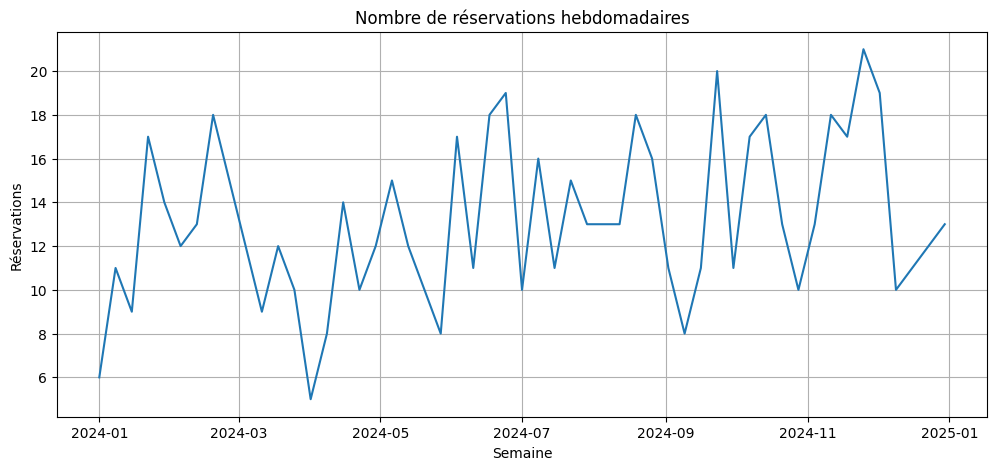

In [8]:
import matplotlib.pyplot as plt

# 4. Affichage de la série temporelle
plt.figure(figsize=(12,5))
plt.plot(df_weekly['reservations'])
plt.title("Nombre de réservations hebdomadaires")
plt.xlabel("Semaine")
plt.ylabel("Réservations")
plt.grid(True)
plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller
# 5. Vérification de stationnarité
result = adfuller(df_weekly['reservations'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.87687512700746
p-value: 3.1443970648587085e-07


ADF vérifie si une série temporelle est stationnaire
H0 (hypothèse nulle) : la série n’est pas stationnaire (elle a une racine unitaire).

H1 (hypothèse alternative) : la série est stationnaire.
ADF Statistic = -5.88 : c’est la statistique de test. Plus elle est faible (négative), plus on a de chances de rejeter H0.

p-value = 3.14e-07 ≈ 0.000000314 : c’est très petit, bien en dessous de n’importe quel seuil classique (0.05, 0.01, etc.).
hypothèse nulle H0 ➜ ta série est stationnaire ✅



In [10]:
from statsmodels.tsa.arima.model import ARIMA

# 6. Modélisation ARIMA
model = ARIMA(df_weekly['reservations'], order=(1,1,1))
model_fit = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [11]:
# 7. Prévision sur 12 semaines
forecast = model_fit.forecast(steps=12)

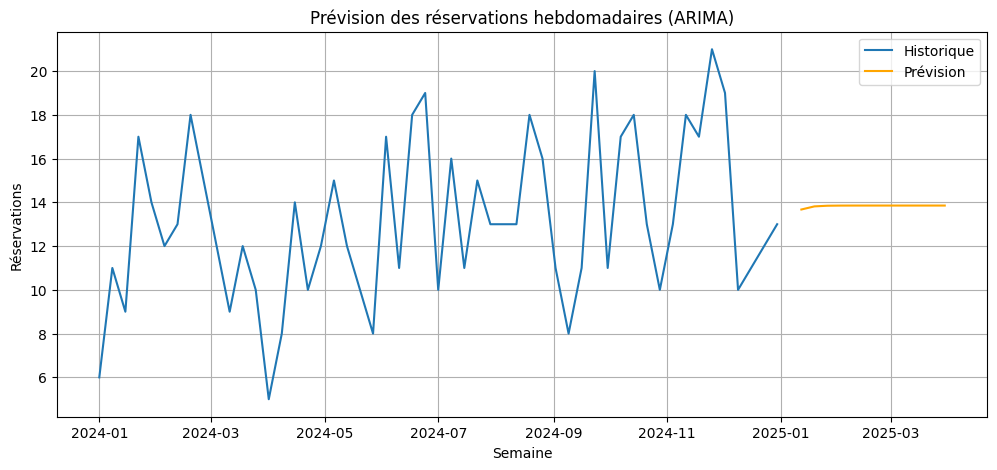

In [12]:
# 8. Affichage de la prévision
plt.figure(figsize=(12,5))
plt.plot(df_weekly['reservations'], label='Historique')
plt.plot(pd.date_range(start=df_weekly.index[-1], periods=13, freq='W')[1:], forecast, label='Prévision', color='orange')
plt.title("Prévision des réservations hebdomadaires (ARIMA)")
plt.xlabel("Semaine")
plt.ylabel("Réservations")
plt.legend()
plt.grid(True)
plt.show()

En bleu : ( Historique ) :  se sont des données réelles dans le passé
En orange : des valeurs prédites pour les semaines futures

In [13]:
print(df_reservations.shape[0])


2500


In [14]:
df_weekly.shape[0]


53

In [15]:
df_weekly['reservations'].describe()


,reservations
count,53.000000
mean,13.113208
std,3.703742
min,5.000000
25%,11.000000
50%,13.000000
75%,16.000000
max,21.000000


In [18]:
# Créer un DataFrame pour la prévision
forecast_dates = pd.date_range(start=df_weekly.index[-1], periods=13, freq='W')[1:]
df_forecast = pd.DataFrame({
    'ds': forecast_dates,
    'reservations_prevision': forecast
})

In [16]:
# Remettre les réservations historiques dans une colonne, pas en index
df_historique = df_weekly.reset_index()[['ds', 'reservations']]


In [19]:
# Fusionner historique + prévision dans un seul DataFrame
df_final = pd.concat([df_historique, df_forecast], axis=0).sort_values('ds')

In [20]:
# Exporter au format CSV
df_final.to_csv('prevision_reservations.csv', index=False)

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA(p,d,q)(P,D,Q,s)
# Exemple : SARIMA(1,1,1)(1,1,1,52) pour saisonnalité annuelle hebdo
sarima_model = SARIMAX(df_weekly['reservations'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,52),  # 52 semaines ≈ 1 an
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

# Prévision sur 12 semaines
sarima_forecast = sarima_fit.forecast(steps=12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       reservations   No. Observations:                   53
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Wed, 23 Apr 2025   AIC                             10.000
Time:                                    12:59:18   BIC                                nan
Sample:                                01-01-2024   HQIC                               nan
                                     - 12-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

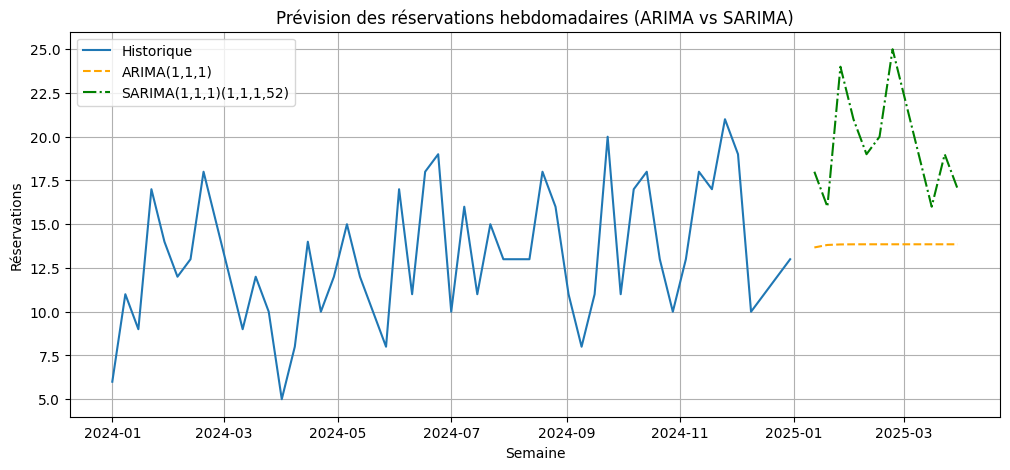

In [22]:
# Dates de prévision
forecast_dates = pd.date_range(start=df_weekly.index[-1], periods=13, freq='W')[1:]

plt.figure(figsize=(12,5))
plt.plot(df_weekly['reservations'], label='Historique')
plt.plot(forecast_dates, forecast, label='ARIMA(1,1,1)', linestyle='--', color='orange')
plt.plot(forecast_dates, sarima_forecast, label='SARIMA(1,1,1)(1,1,1,52)', linestyle='-.', color='green')
plt.title("Prévision des réservations hebdomadaires (ARIMA vs SARIMA)")
plt.xlabel("Semaine")
plt.ylabel("Réservations")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Dates de prévision
forecast_dates = pd.date_range(start=df_weekly.index[-1], periods=13, freq='W')[1:]

# Créer un DataFrame pour la prévision SARIMA
df_sarima = pd.DataFrame({
    'ds': forecast_dates,
    'prevision_sarima': sarima_forecast
})

# Historique
df_historique = df_weekly.reset_index()[['ds', 'reservations']]

# Fusionner historique + prévision
df_export = pd.concat([df_historique, df_sarima], axis=0).sort_values('ds')


In [24]:
df_export.to_csv('prevision_sarima_reservations.csv', index=False)
